# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [7]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [8]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [9]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9200000000000002


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

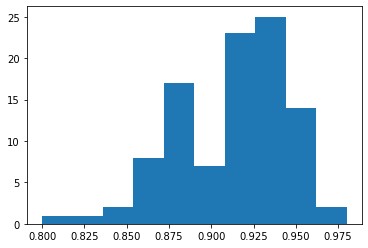

In [10]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (6 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

### Report:

* In this task, we are dealing with a supervised feature extraction and we are using both train and validation data for feature extraction simultaneously, so our validation data is leaked to the training phase. This means we are using the wrong feature extraction.

* It seems that our initial data generation is independent, but because the dimension of the dataset is very high (1K features and just 100 samples), then in the feature extraction phase it just selects those features which have the highest covariance even for validation data.

* As a solution, we first divided the whole dataset based on the index obtained from KFold then for training we use feature transform by `X_train`, `y_train` to generate `X_train_best` but, for the validation part, we use `X_test` to generate `X_test_best` to prevent the leakage. Therefore, we obtained the expected accuracy based on the logic of our problem.

Done!

First 10 scores:
 [0.55, 0.47000000000000003, 0.6199999999999999, 0.61, 0.42000000000000004, 0.58, 0.52, 0.5399999999999998, 0.38999999999999996, 0.41] 



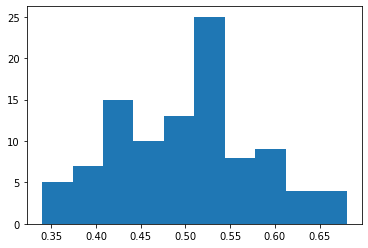

In [14]:
num_features_total = 1000
num_features_best = 100

N = 100

def my_experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  scores = []
  kf = KFold(n_splits=10)
  for train_index , test_index in kf.split(X):
    X_train , X_test = X[train_index,:], X[test_index,:]
    y_train , y_test = y[train_index], y[test_index]     
    # Feature selection:
    featureSelector = FeatureSelector(num_features_best)
    X_train_best = featureSelector.fit_transform(X_train, y_train)
    X_test_best = featureSelector.transform(X_test)
    # Simple classification model
    model = LinearSVC()
    # Estimatin accuracy using cross-validation:
    model.fit(X_train_best, y_train)
    scores.append(sum(model.predict(X_test_best) == y_test) / len(y_test))
    
  return np.array(scores).mean()

results = [my_experiment() for _ in range(100)]
print('First 10 scores:\n', results[:10], '\n')
plt.hist(results, bins=10);